In [1]:
from casadi import Opti,log,exp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Randomly initialize parameters. Individuals and facilities are distributed uniformly randomly around a unit square. Individual types $\theta_i \sim \text{Bernoulli}(\frac{1}{2})$. That is,
$$
\theta_i=\begin{cases} 
0 : \text{ w.p. } \frac{1}{2}\\
1 : \text{ w.p. } \frac{1}{2}.
\end{cases}
$$

Distances between individuals and facilities are stored in matrix `dist`.

In [2]:
sizeRegion = 1
nIndiv = 18
nFac = 5
nSelectedFac = 2
fac = np.random.uniform(0,sizeRegion,(nFac, 2))
indiv = np.random.uniform(0,sizeRegion,(nIndiv, 2))
theta = np.array([np.random.choice([0,1]) for i in range(nIndiv)])
dist = np.array([[ (indiv[i,0] - fac[j,0])**2 + (indiv[i,1] - fac[j,1])**2 for j in range(0,nFac)] for i in range(0,nIndiv)]) # nIndiv X nFac

The stochastic model is that

$$
P(\text{success of individual } i) = f(\theta_i,r_i)= \frac{1}{1 + e^{-(\beta_0 + \beta_\theta \theta_i + \beta_r r_i)}}.
$$
where $r_i$ represents the distance of individual $i$ from the nearest selected facility, and $\beta_r <0$ indicates that increasing distance causes decreased probability of success. Higher type $\theta_i$ corresponds to a higher probability of success, so $\beta_\theta >0$.

In this code, $\beta_0=0$, so a type-$0$ individual ($\theta_i = 0$) with no distance to the nearest facility ($r_i=0$) has precisely a $\frac{1}{2}$ probability of success. Increasing $\beta_0$ increases the probability of success for all individuals.

We let $\beta = (\beta_0, \beta_\theta, \beta_r)$.

In [3]:
beta = [0,10,-1] #[beta0, beta_theta >0, beta_r <0]

We implement the following optimization model in the `CasADI` Python interface to COIN-OR's `Bonmin` MINLP solver:

$$
\begin{array}{llll}
            \max & \displaystyle\sum_{i=1}^N u_i & &\\
            \text{s.t.} & u_i &= f(\theta_i,r_i),&i = 1,\ldots,N\\
                        & r_i &\ge d_{ij} x_{ij},&i=1,\ldots,N,j=1,\ldots,M\\
                        & \displaystyle\sum_{j=1}^M x_{ij} &=1,&i=1,\ldots,N\\
                        & x_{ij} &\le y_j, &i=1,\ldots,N,j=1,\ldots,M\\
                        &\displaystyle\sum_{j=1}^M y_j &\le m&\\
                        & x_{ij},y_j &\in \{0,1\},&i=1,\ldots,N,j=1,\ldots,M. 
\end{array}
$$

In [4]:
opti = Opti()
x = [[opti.variable() for j in range(nFac)] for i in range(nIndiv)] # nIndiv X nFac
y = [opti.variable() for j in range(nFac)]
r = [opti.variable() for i in range(nIndiv)]
u = [opti.variable() for i in range(nIndiv)]
discrete = []
discrete += [True  for j in range(nFac) for i in range(nIndiv)] #x variables
discrete += [True  for j in range(nFac)] #y variables
discrete += [False for i in range(nIndiv)] #r variables
discrete += [False for i in range(nIndiv)] #u variables
opti.minimize(-sum(u))#maximize sum u
opti.subject_to([u[i] == -log(1+exp(-beta[0] - beta[1]*theta[i] - beta[2]*r[i])) for i in range(nIndiv)])
opti.subject_to([r[i] >= dist[i,j]*x[i][j] for i in range(nIndiv) for j in range(nFac)])
opti.subject_to([ sum(x[i]) == 1 for i in range(nIndiv) ])
opti.subject_to([ x[i][j] <= y[j] for i in range(nIndiv) for j in range(nFac)])
opti.subject_to(sum(y) <= nSelectedFac)
opti.subject_to([ opti.bounded(0,y[j],1) for j in range(nFac)])
opti.subject_to([ opti.bounded(0,x[i][j],1) for i in range(nIndiv) for j in range(nFac)])
p_options = {"discrete":discrete,"expand":True}
s_options = {"max_iter": 100}
opti.solver('bonmin',p_options,s_options)
sol = opti.solve()
xvals = np.array([[int(sol.value(x[i][j])) for j in range(nFac)] for i in range(nIndiv)])
yvals = np.array([int(sol.value(y[j])) for j in range(nFac)])
rvals = np.array([sol.value(r[i]) for i in range(nIndiv)])
uvals = np.array([sol.value(u[i]) for i in range(nIndiv)])
fstar = sol.value(opti.f)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 7.1512609       19 0.026824
NLP0014I             2         OPT 7.186353       17 0.023516
NLP0014I             3         OPT 7.1970107       19 0.028594
NLP0014I             4         OPT 7.1843208       17 0.021951
NLP0014I             5         OPT 7.2018012       23 0.031225
NLP0014I             6         OPT 7.1708226       15 0.020548
NLP0014I             7         OPT 7.2130376       21 0.02867
NLP0014I             8         OPT 7.2372489       19 0.028793
NLP0014I  

NLP0014I           123         OPT 7.2594494       19 0.023826
NLP0014I           124         OPT 7.1576428       19 0.02262
NLP0014I           125         OPT 7.3047032       23 0.030783
NLP0014I           126         OPT 7.1570684       12 0.015408
NLP0014I           127         OPT 7.5851428       23 0.027301
NLP0014I           128         OPT 7.1512617       14 0.017783
NLP0014I           129         OPT 7.1940639       19 0.025367
NLP0014I           130         OPT 7.1560642       15 0.019507
NLP0014I           131         OPT 7.5492246       21 0.026148
NLP0014I           132         OPT 7.1512616       15 0.019636
NLP0014I           133         OPT 7.2119755       23 0.0271
NLP0014I           134         OPT 7.1568141       12 0.014696
NLP0014I           135         OPT 7.6379648       21 0.025683
NLP0014I           136         OPT 7.1568544       17 0.023459
NLP0014I           137         OPT 7.3450587       21 0.036033
NLP0014I           138         OPT 7.1537404       14 0.02

NLP0014I           250         OPT 7.5724544       18 0.026255
NLP0014I           251         OPT 7.5724647       17 0.023799
NLP0014I           252         OPT 7.5724551       18 0.028459
NLP0014I           253         OPT 7.5724671       18 0.026318
NLP0014I           254         OPT 7.5724628       18 0.026998
NLP0014I           255         OPT 7.5724633       18 0.027238
NLP0014I           256         OPT 7.5724663       18 0.025249
NLP0014I           257         OPT 7.5724952       19 0.027062
NLP0014I           258         OPT 7.5724714       16 0.025111
NLP0012I 
              Num      Status      Obj             It       time                 Location
NLP0014I             1         OPT 7.5724718        4 0.004618
Cbc0004I Integer solution of 7.5724718 found after 1242 iterations and 67 nodes (6.78 seconds)
NLP0014I           259         OPT 7.4861344       23 0.029073
NLP0014I           260         OPT 8.089181       18 0.025093
NLP0012I 
              Num      Status      Obj  

Plot the solution:

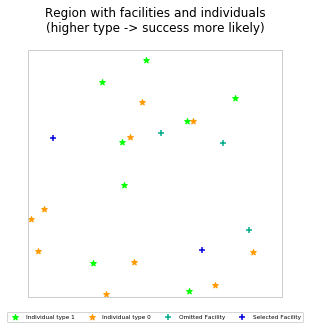

In [8]:
def plot_region():
	number_desired_colors = 6
	cmap = plt.cm.get_cmap('nipy_spectral',number_desired_colors)
	colors = [cmap(i) for i in range(number_desired_colors)]
	fig, ax = plt.subplots(figsize=(5,5))
	plt.axis('off')
	plt.title(f"Region with facilities and individuals\n(higher type -> success more likely)")
	## Plot Region
	region = patches.Rectangle((0,0),sizeRegion,sizeRegion,linewidth=1,edgecolor=colors.pop(),facecolor="none")
	ax.add_patch(region)
	## Plot Individuals
	labelIndividuals = "Individual"
	def plotIndividuals():
		color_weight_map = {ttheta : colors.pop() for ttheta in set(theta)}
		individual_colors = [color_weight_map[ttheta] for ttheta in theta]
		individual_labels = [f"{labelIndividuals} type {ttheta}" for coords,ttheta in zip(indiv,theta)]
		for i,coords in enumerate(indiv):
			plt.scatter(*coords,marker = "*",c=[individual_colors[i]],label=individual_labels[i])
	plotIndividuals()
	## Plot Facilities
	labelFacility = "Facility"
	def plotFacilities():
		facility_color_map = {yval : colors.pop() for yval in set(yvals)}
		facility_colors = [facility_color_map[yval] for yval in yvals]
		facility_states = ["Omitted", "Selected"]
		facility_labels = [f"{facility_states[yval]} {labelFacility}" for yval in yvals]
		for i, coords in enumerate(fac):
			plt.scatter(*coords,marker = "+",c=[facility_colors[i]],label=facility_labels[i])
	plotFacilities()
	## Create Legend
	legend_dict = {artist.properties().get('label') : artist for artist in ax.collections.copy() + ax.lines.copy()}
	plt.legend(legend_dict.values(),legend_dict.keys(),loc='upper center', bbox_to_anchor=(0.5, 0), ncol=len(legend_dict),fontsize='xx-small') #,loc="upper right"
	plt.show(block=False)
	return fig,ax

fig,ax = plot_region()